# Implementation of ericsuh/dirichlet with some tests

https://github.com/ericsuh/dirichlet

In [1]:
#from numpy import (array, asanyarray, ones, arange, log, diag, vstack, exp,
#        asarray, ndarray, zeros, isscalar)

import numpy as np
from numpy import (array, asanyarray, ones, arange, log, diag, vstack, exp,
        asarray, ndarray, zeros, isscalar)
from scipy.special import (psi, polygamma, gammaln)
import sys
from numpy.linalg import norm

try:
    # python 2
    MAXINT = sys.maxint
except AttributeError:
    # python 3
    MAXINT = sys.maxsize
    
    
euler = -1*psi(1) # Euler-Mascheroni constant


## Fit Functions

In [2]:
def _fit_s(D, a0, logp, tol=1e-7, maxiter=1000):
    '''Assuming a fixed mean for Dirichlet distribution, maximize likelihood
    for preicision a.k.a. s'''
    N, K = D.shape
    s1 = a0.sum()
    m = a0 / s1
    mlogp = (m*logp).sum()
    for i in range(maxiter):
        s0 = s1
        g = psi(s1) - (m*psi(s1*m)).sum() + mlogp
        h = _trigamma(s1) - ((m**2)*_trigamma(s1*m)).sum()

        if g + s1 * h < 0:
            s1 = 1/(1/s0 + g/h/(s0**2))
        if s1 <= 0:
            s1 = s0 * exp(-g/(s0*h + g)) # Newton on log s
        if s1 <= 0:
            s1 = 1/(1/s0 + g/((s0**2)*h + 2*s0*g)) # Newton on 1/s
        if s1 <= 0:
            s1 = s0 - g/h # Newton
        if s1 <= 0:
            raise Exception('Unable to update s from {}'.format(s0))

        a = s1 * m
        if abs(s1 - s0) < tol:
            return a
        
def _fit_m(D, a0, logp, tol=1e-7, maxiter=1000):
    '''With fixed precision s, maximize mean m'''
    N,K = D.shape
    s = a0.sum()

    for i in range(maxiter):
        m = a0 / s
        a1 = _ipsi(logp + (m*(psi(a0) - logp)).sum())
        a1 = a1/a1.sum() * s

        if norm(a1 - a0) < tol:
            return a1
        a0 = a1

    raise Exception('Failed to converge after {} iterations, s is {}'
            .format(maxiter, s))

## Math Helper Functions

In [3]:
def _ipsi(y, tol=1.48e-9, maxiter=10):
    '''Inverse of psi (digamma) using Newton's method. For the purposes
    of Dirichlet MLE, since the parameters a[i] must always
    satisfy a > 0, we define ipsi :: R -> (0,inf).'''
    y = asanyarray(y, dtype='float')
    x0 = _piecewise(y, [y >= -2.22, y < -2.22],
            [(lambda x: exp(x) + 0.5), (lambda x: -1/(x+euler))])
    for i in range(maxiter):
        x1 = x0 - (psi(x0) - y)/_trigamma(x0)
        if norm(x1 - x0) < tol:
            return x1
        x0 = x1
    raise Exception(
        'Unable to converge in {} iterations, value is {}'.format(maxiter, x1))
    
def _trigamma(x):
    return polygamma(1, x)

def _piecewise(x, condlist, funclist, *args, **kw):
    '''Fixed version of numpy.piecewise for 0-d arrays'''
    x = asanyarray(x)
    n2 = len(funclist)
    if isscalar(condlist) or \
            (isinstance(condlist, np.ndarray) and condlist.ndim == 0) or \
            (x.ndim > 0 and condlist[0].ndim == 0):
        condlist = [condlist]
    condlist = [asarray(c, dtype=bool) for c in condlist]
    n = len(condlist)

    zerod = False
    # This is a hack to work around problems with NumPy's
    #  handling of 0-d arrays and boolean indexing with
    #  numpy.bool_ scalars
    if x.ndim == 0:
        x = x[None]
        zerod = True
        newcondlist = []
        for k in range(n):
            if condlist[k].ndim == 0:
                condition = condlist[k][None]
            else:
                condition = condlist[k]
            newcondlist.append(condition)
        condlist = newcondlist

    if n == n2-1:  # compute the "otherwise" condition.
        totlist = condlist[0]
        for k in range(1, n):
            totlist |= condlist[k]
        condlist.append(~totlist)
        n += 1
    if (n != n2):
        raise ValueError(
                "function list and condition list must be the same")

    y = zeros(x.shape, x.dtype)
    for k in range(n):
        item = funclist[k]
        if not callable(item):
            y[condlist[k]] = item
        else:
            vals = x[condlist[k]]
            if vals.size > 0:
                y[condlist[k]] = item(vals, *args, **kw)
    if zerod:
        y = y.squeeze()
    return y

## Dirichlet

In [4]:
def pdf(alphas):
    '''Returns a Dirichlet PDF function'''
    alphap = alphas - 1
    c = np.exp(gammaln(alphas.sum()) - gammaln(alphas).sum())
    def dirichlet(xs):
        '''N x K array'''
        return c * (xs**alphap).prod(axis=1)
    return dirichlet

def meanprecision(a):
    '''Mean and precision of Dirichlet distribution.
    Parameters
    ----------
    a : array
        Parameters of Dirichlet distribution.
    Returns
    -------
    mean : array
        Numbers [0,1] of the means of the Dirichlet distribution.
    precision : float
        Precision or concentration parameter of the Dirichlet distribution.'''

    s = a.sum()
    m = a / s
    return (m,s)
def mle(D, tol=1e-7, method='meanprecision', maxiter=None):
    '''Iteratively computes maximum likelihood Dirichlet distribution
    for an observed data set, i.e. a for which log p(D|a) is maximum.
    Parameters
    ----------
    D : 2D array
        ``N x K`` array of numbers from [0,1] where ``N`` is the number of
        observations, ``K`` is the number of parameters for the Dirichlet
        distribution.
    tol : float
        If Euclidean distance between successive parameter arrays is less than
        ``tol``, calculation is taken to have converged.
    method : string
        One of ``'fixedpoint'`` and ``'meanprecision'``, designates method by
        which to find MLE Dirichlet distribution. Default is
        ``'meanprecision'``, which is faster.
    maxiter : int
        Maximum number of iterations to take calculations. Default is
        ``sys.maxint``.
    Returns
    -------
    a : array
        Maximum likelihood parameters for Dirichlet distribution.'''

    if method == 'meanprecision':
        return _meanprecision(D, tol=tol, maxiter=maxiter)
    else:
        return _fixedpoint(D, tol=tol, maxiter=maxiter)

def loglikelihood(D, a):
    '''Compute log likelihood of Dirichlet distribution, i.e. log p(D|a).
    Parameters
    ----------
    D : 2D array
        where ``N`` is the number of observations, ``K`` is the number of
        parameters for the Dirichlet distribution.
    a : array
        Parameters for the Dirichlet distribution.
    Returns
    -------
    logl : float
        The log likelihood of the Dirichlet distribution'''
    N, K = D.shape
    logp = log(D).mean(axis=0)
    return N*(gammaln(a.sum()) - gammaln(a).sum() + ((a - 1)*logp).sum())    

def _fixedpoint(D, tol=1e-7, maxiter=None):
    '''Simple fixed point iteration method for MLE of Dirichlet distribution'''
    N, K = D.shape
    logp = log(D).mean(axis=0)
    a0 = _init_a(D)

    # Start updating
    if maxiter is None:
        maxiter = MAXINT
    for i in range(maxiter):
        a1 = _ipsi(psi(a0.sum()) + logp)
        # if norm(a1-a0) < tol:
        if abs(loglikelihood(D, a1)-loglikelihood(D, a0)) < tol: # much faster
            return a1
        a0 = a1
    raise Exception('Failed to converge after {} iterations, values are {}.'
                    .format(maxiter, a1))

def _meanprecision(D, tol=1e-7, maxiter=None):
    '''Mean and precision alternating method for MLE of Dirichlet
    distribution'''
    N, K = D.shape
    logp = log(D).mean(axis=0)
    a0 = _init_a(D)
    s0 = a0.sum()
    if s0 < 0:
        a0 = a0/s0
        s0 = 1
    elif s0 == 0:
        a0 = ones(a.shape) / len(a)
        s0 = 1
    m0 = a0/s0

    # Start updating
    if maxiter is None:
        maxiter = MAXINT
    for i in range(maxiter):
        a1 = _fit_s(D, a0, logp, tol=tol)
        s1 = sum(a1)
        a1 = _fit_m(D, a1, logp, tol=tol)
        m = a1/s1
        # if norm(a1-a0) < tol:
        if abs(loglikelihood(D, a1)-loglikelihood(D, a0)) < tol: # much faster
            return a1
        a0 = a1
    raise Exception('Failed to converge after {} iterations, values are {}.'
                    .format(maxiter, a1))
def _init_a(D):
    '''Initial guess for Dirichlet alpha parameters given data D'''
    E = D.mean(axis=0)
    E2 = (D**2).mean(axis=0)
    return ((E[0] - E2[0])/(E2[0]-E[0]**2)) * E

    raise Exception('Failed to converge after {} iterations, s is {}'
            .format(maxiter, s1))

## Test Dirichlet Stuff

In [5]:
np.random.seed(12987529)
a0 = np.array([100, 299, 100])
D0 = np.random.dirichlet(a0, 1000)

In [6]:
def test_mle(method):
    
    a0_fit = mle(D0, method=method)
    logl0_fit = loglikelihood(D0, a0_fit)
    print(logl0_fit)
def test_loglikelihood():
    logl0 = loglikelihood(D0, a0)

    a1 = np.array([50, 50, 90])
    D1 = np.random.dirichlet(a1, 1000)
    logl1 = loglikelihood(D1, a1)

    print(logl0)
    print(logl1)

In [7]:
test_mle('fixedpoint')
test_mle('meanprecision')

test_loglikelihood()

5270.302503619632
5270.302529465425
5269.609221014889
4112.623053555524


# Simplex

In [8]:
import matplotlib
import matplotlib.pyplot as plt

In [9]:
def cartesian(points):
    '''Converts array of barycentric coordinates on a 2-simplex to an array of
    Cartesian coordinates on a 2D triangle in the first quadrant, i.e.::
        >>> cartesian((1,0,0))
        array([0, 0])
        >>> cartesian((0,1,0))
        array([0, 1])
        >>> cartesian((0,0,1))
        array([0.5, 0.8660254037844386]) # == [0.5, sqrt(3)/2]
    :param points: Points on a 2-simplex.
    :type points: N x 3 list or ndarray.
    :returns: Cartesian coordinate points.
    :rtype: N x 2 ndarray.'''
    points = np.asanyarray(points)
    ndim = points.ndim # will use this to have similar output shape to input
    if ndim == 1:
        points = points.reshape((1,points.size))
    d = points.sum(axis=1) # in case values aren't normalized
    x = 0.5*(2*points[:,1] + points[:,2])/d
    y = (np.sqrt(3.0)/2) * points[:,2]/d
    out = np.vstack([x,y]).T
    if ndim == 1:
        return out.reshape((2,))
    return out
def barycentric(points):
    '''Inverse of :func:`cartesian`.'''
    points = np.asanyarray(points)
    ndim = points.ndim
    if ndim == 1:
        points = points.reshape((1,points.size))
    c = (2/np.sqrt(3.0))*points[:,1]
    b = (2*points[:,0] - c)/2.0
    a = 1.0 - c - b
    out = np.vstack([a,b,c]).T
    if ndim == 1:
        return out.reshape((3,))
    return out
def contour(f, vertexlabels=None, **kwargs):
    '''Contour line plot on a 2D triangle of a function evaluated at
    barycentric 2-simplex points.
    :param f: Function to evaluate on N x 3 ndarray of coordinates
    :type f: ``ufunc``
    :param vertexlabels: Labels for corners of plot in the order
        ``(a, b, c)`` where ``a == (1,0,0)``, ``b == (0,1,0)``,
        ``c == (0,0,1)``.
    :type vertexlabels: 3-tuple of strings.
    :param **kwargs: Arguments to :func:`plt.tricontour`.
    :type **kwargs: keyword arguments.'''
    return _contour(f, vertexlabels, contourfunc=plt.tricontour, **kwargs)
def contourf(f, vertexlabels=None, **kwargs):
    '''Filled contour plot on a 2D triangle of a function evaluated at
    barycentric 2-simplex points.
    Function signature is identical to :func:`contour` with the caveat that
    ``**kwargs`` are passed on to :func:`plt.tricontourf`.'''
    return _contour(f, vertexlabels, contourfunc=plt.tricontourf, **kwargs)
def scatter(points, vertexlabels=None, **kwargs):
    '''Scatter plot of barycentric 2-simplex points on a 2D triangle.
    :param points: Points on a 2-simplex.
    :type points: N x 3 list or ndarray.
    :param vertexlabels: Labels for corners of plot in the order
        ``(a, b, c)`` where ``a == (1,0,0)``, ``b == (0,1,0)``,
        ``c == (0,0,1)``.
    :type vertexlabels: 3-tuple of strings.
    :param **kwargs: Arguments to :func:`plt.scatter`.
    :type **kwargs: keyword arguments.'''
    if vertexlabels is None:
        vertexlabels = ('1','2','3')

    projected = cartesian(points)
    plt.scatter(projected[:,0], projected[:,1], **kwargs)

    _draw_axes(vertexlabels)
    return plt.gcf()

In [10]:
def _draw_axes(vertexlabels):
    l1 = matplotlib.lines.Line2D([0,0.5,1.0,0],
                                 [0, np.sqrt(3)/2, 0, 0],
                                 color='k')
    axes = plt.gca()
    axes.add_line(l1)
    axes.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    axes.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    axes.text(-0.05, -0.05, vertexlabels[0])
    axes.text(1.05, -0.05, vertexlabels[1])
    axes.text(0.5, np.sqrt(3) / 2 + 0.05, vertexlabels[2])
    axes.set_xlim(-0.2, 1.2)
    axes.set_ylim(-0.2, 1.2)
    axes.set_aspect('equal')
    return axes
def _contour(f, vertexlabels=None, contourfunc=None, **kwargs):
    '''Workhorse function for countour function, where ``contourfunc`` is the contour
    plotting function to use for actual plotting.'''

    if contourfunc is None:
        contourfunc = plt.tricontour
    if vertexlabels is None:
        vertexlabels = ('1','2','3')
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, np.sqrt(3.0)/2.0, 100)
    points2d = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    points3d = barycentric(points2d)
    valid = (points3d.sum(axis=1) == 1.0) & ((0.0 <= points3d).all(axis=1))
    points2d = points2d[np.where(valid),:][0]
    points3d = points3d[np.where(valid),:][0]
    z = f(points3d)
    contourfunc(points2d[:,0], points2d[:,1], z, **kwargs)
    _draw_axes(vertexlabels)
    return plt.gcf()

In [11]:
plt.clf()

# Test mle with some sample distributions

a = np.array([0.1, 0.1, 0.3])
D = np.random.dirichlet(a, 1000)
m = mle(D)
print(m)

a1 = np.array([50, 50, 90])
D1 = np.random.dirichlet(a1, 1000)
m1 = mle(D1)
print(m1)
m = [m]
scatter(m)

print(loglikelihood(D,a))

[0.09777017 0.09459414 0.27673159]
[47.97987931 47.57595486 85.72591953]
11818.609407183807


[[0.37111829 0.28449214 0.34438957]
 [0.33198226 0.33938262 0.32863512]
 [0.24767941 0.39691965 0.35540094]
 ...
 [0.37860868 0.42274382 0.1986475 ]
 [0.39035224 0.29251252 0.31713524]
 [0.30382666 0.35424362 0.34192971]]


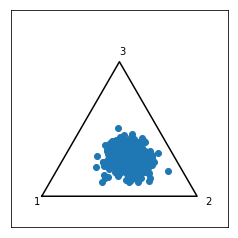

In [12]:
plt.clf()
a = np.array([10, 15, 10])
D = np.random.dirichlet(a, 500)
m = mle(D)
print(D)
m = [m]
scatter(D)

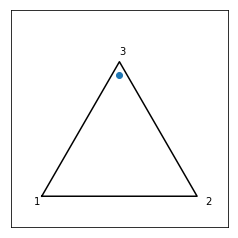

In [13]:
plt.clf()
prob_sample = [0.9, 0.05 ,0.05]


prob_sample.sort(reverse=False);

prob_sample = [prob_sample]
scatter(prob_sample)